## Imports

In [1]:
import tensorflow.keras
import sklearn as sk
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.xception import Xception
from tensorflow.keras.applications.xception import decode_predictions
import urllib.request
import io
from sklearn.linear_model import LassoCV
from sklearn.metrics.pairwise import cosine_distances
import cv2
import cv2.ximgproc
from sklearn.linear_model import LinearRegression


print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Scikit-Learn 1.1.3
GPU is available


## The below images were chosen and are displayed because they are cute and cool

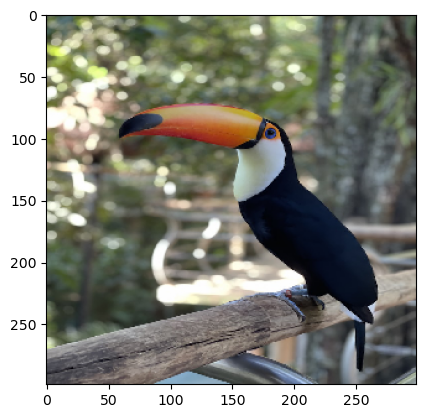

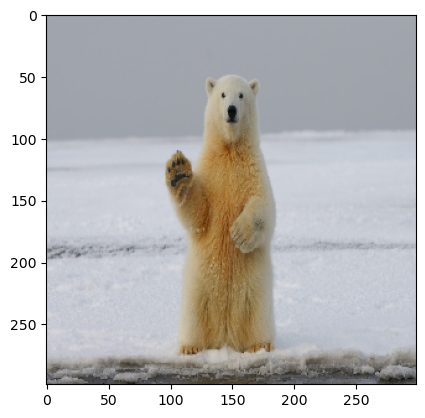

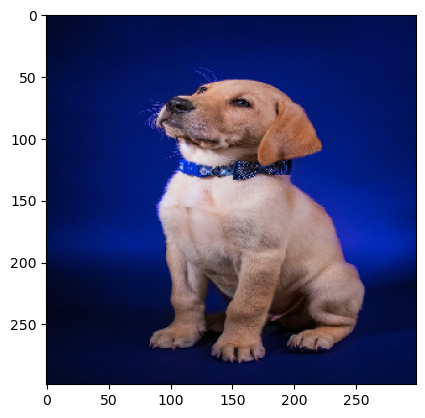

In [2]:
img1_url = 'https://images.unsplash.com/photo-1619038779484-a27362fb82cd?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=735&q=80'
img2_url = 'https://images.unsplash.com/photo-1589656966895-2f33e7653819?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1470&q=80'
#img3_url = 'https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8YW5pbWFsc3xlbnwwfHwwfHx8MA%3D%3D&auto=format&fit=crop&w=500&q=60'
img3_url = 'https://images.unsplash.com/photo-1587764379873-97837921fd44?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=687&q=80'
images_list = [img1_url,img2_url,img3_url]
images = []
for IMAGE_URL in images_list:
    # Read the image file from the URL
    with urllib.request.urlopen(IMAGE_URL) as url:
        img_data = url.read()

    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(io.BytesIO(img_data), target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)
    # View the image
    plt.imshow(img/255.)
    plt.show()


## We will be using Xception as our pre trained image classification model

In [3]:
# Load the Xcepetion pretrained on ImageNet
Xception_ = Xception(weights='imagenet', include_top=True)
#, input_shape=input_shape , pooling='avg'  model = 'resnet50', 

print(Xception_.summary())

Metal device set to: Apple M1 Pro


2023-07-06 18:46:04.805310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-06 18:46:04.805720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

## General functions to be used

In [4]:
def get_top3(img):
    img_ = img.copy()
    #Xception_ = Xception(weights='imagenet', include_top=True) # This is because of a bug
    img_ = tf.keras.applications.xception.preprocess_input(img_)
    predictions = Xception_.predict(np.array([img_]),verbose = 0)
    return decode_predictions(predictions,top=3), predictions

In [5]:
def get_interpretable_instances(img):
    # Perform superpixel segmentation using the CV2 package
    img_ = img.copy()
    segments = cv2.ximgproc.createSuperpixelSLIC(img_, region_size=25, ruler=5.0)
    segments.iterate(num_iterations=100)

    # Get the superpixel labels and the number of superpixels
    labels = segments.getLabels()
    num_superpixels = segments.getNumberOfSuperpixels()
   
    
    # Get the coordinates of each superpixel
    superpixel_coords = []
    for label in range(num_superpixels):
        indices = np.where(labels == label)  # Find indices where the label matches
        coords = np.column_stack(indices)  # Stack row and column indices
        superpixel_coords.append(np.array(coords))
    
    
    interpretable_instances = []
    # Iterate over each superpixel and create a binary vector for each interpretable version
    for i in range(num_superpixels):
        interpretable_instance = np.ones((num_superpixels,), dtype=int)
        interpretable_instances.append(interpretable_instance)

    return interpretable_instances, segments, superpixel_coords

In [6]:
def represent_as_binary_vectors(interpretable_instances):
    binary_vectors = []
    for interpretable_instance in interpretable_instances:
        binary_vectors.append(interpretable_instance.astype(int))
    return np.array(binary_vectors)

In [7]:
def generate_random_perturbations(interpretable_instances):
    perturbations = []
    for interpretable_instance in interpretable_instances:
        d = len(interpretable_instance)
        perturbation = np.random.choice([0, 1], size=d)
        perturbations.append(perturbation)
    return perturbations

In [8]:
def generate_image_from_interpretable_instance(interpretable_instances, superpixel_coords, image_shape, original_image):
    images = []
    labels = []
    label_indices = []
    probs = []
    
    for interpretable_instance in interpretable_instances:
        image = np.zeros(image_shape)  # Step 2: Create an empty image

        for i, included in enumerate(interpretable_instance):
            if included == 1:
                superpixel_coords_i = superpixel_coords[i]
                for coord in superpixel_coords_i:
                    image[coord[0], coord[1]] = original_image[coord[0], coord[1]]  # Set pixel values from original image


        top, predictions = get_top3(image*255)
        label = top[0][0][1]
        label_index = predictions[0].argsort()[-1:][::-1]
        prob = top[0][0][2]
        images.append(image)
        labels.append(label)
        label_indices.append(label_index)
        probs.append(prob)
        
    
    return np.array(images), np.array(labels), np.array(label_indices), np.array(probs)

In [9]:
def calculate_similarity_full(original_image, perturbed_instances):
    original_image = original_image.reshape(1, -1)
    # Compute the cosine distances
    temp = []
    for perturbed_instance in perturbed_instances:
        perturbed_instance = perturbed_instance.reshape(1, -1)
        temp.append(cosine_distances(original_image, perturbed_instance)[0][0])
        
    distances = np.array(temp)
    std = np.std(distances)
    
    similarity = np.exp(-(distances)**2 / (std ** 2))
    
    return similarity

# Lasso

The image we are investigating is: 


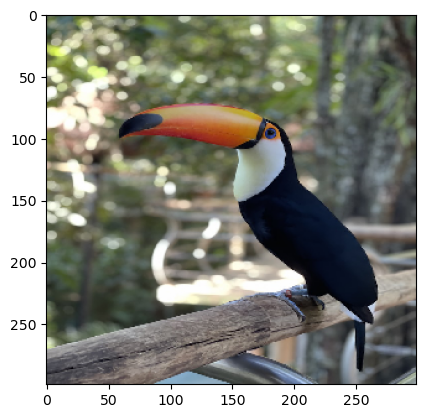

2023-07-06 18:46:06.543037: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-06 18:46:06.729977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The top 3 predicted classes for this image are:  ['toucan', 'macaw', 'jacamar']
The image with the superpixel segments is: 


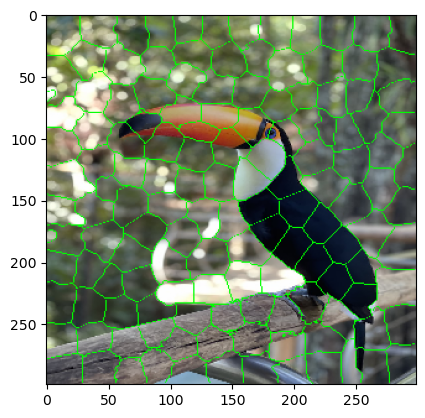

We are now considering class:  toucan
Below we will show the image explaining this prediction (the above class is the prediction)


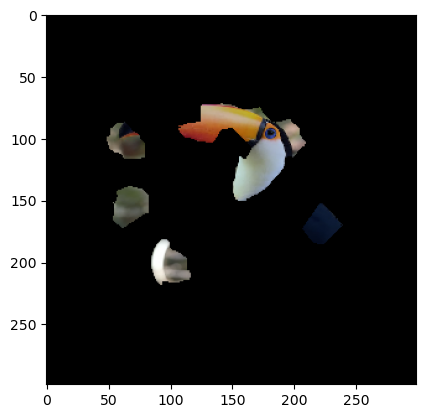

We are now considering class:  macaw
Below we will show the image explaining this prediction (the above class is the prediction)


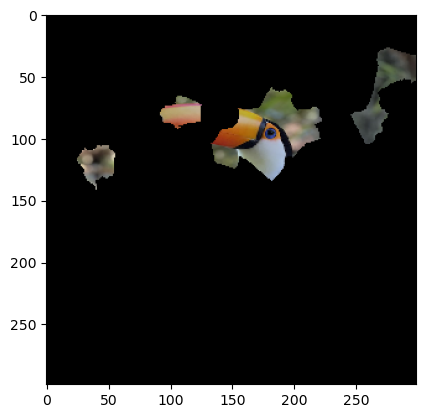

We are now considering class:  jacamar
Below we will show the image explaining this prediction (the above class is the prediction)


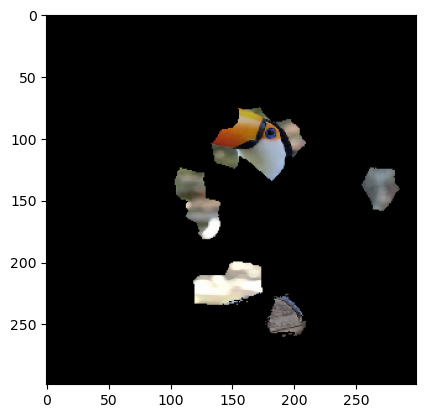

The image we are investigating is: 


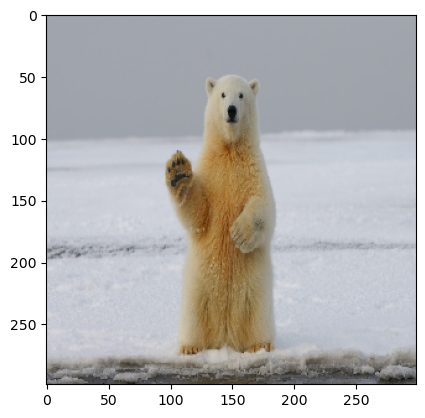

The top 3 predicted classes for this image are:  ['ice_bear', 'Arctic_fox', 'white_wolf']
The image with the superpixel segments is: 


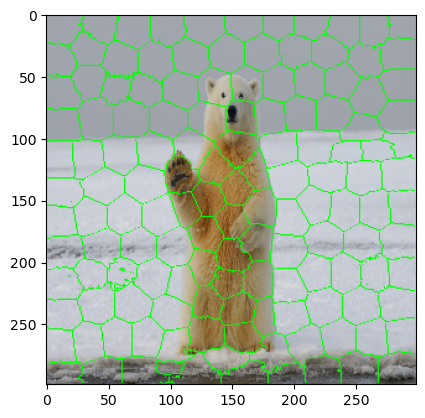

We are now considering class:  ice_bear
Below we will show the image explaining this prediction (the above class is the prediction)


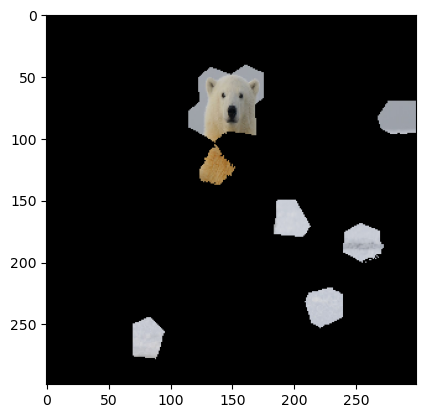

We are now considering class:  Arctic_fox
Below we will show the image explaining this prediction (the above class is the prediction)


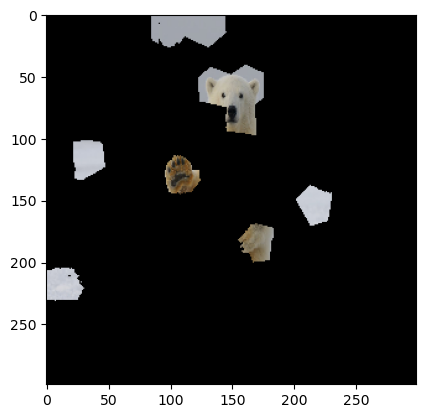

We are now considering class:  white_wolf
Below we will show the image explaining this prediction (the above class is the prediction)


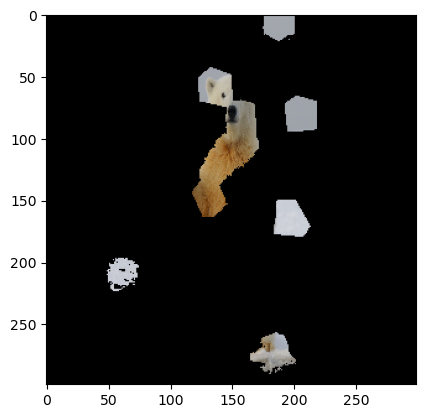

The image we are investigating is: 


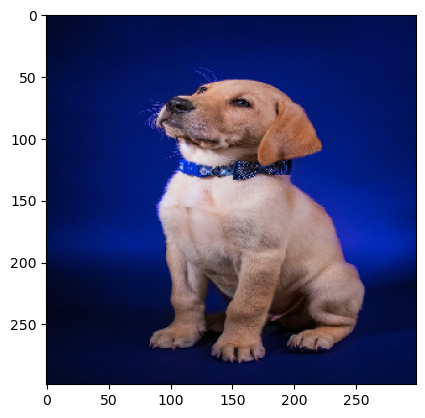

The top 3 predicted classes for this image are:  ['Labrador_retriever', 'golden_retriever', 'beagle']
The image with the superpixel segments is: 


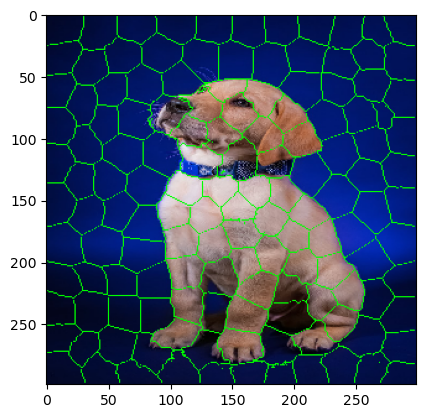

We are now considering class:  Labrador_retriever
Below we will show the image explaining this prediction (the above class is the prediction)


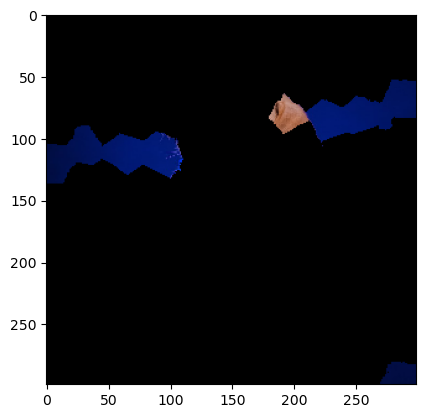

We are now considering class:  golden_retriever
Below we will show the image explaining this prediction (the above class is the prediction)


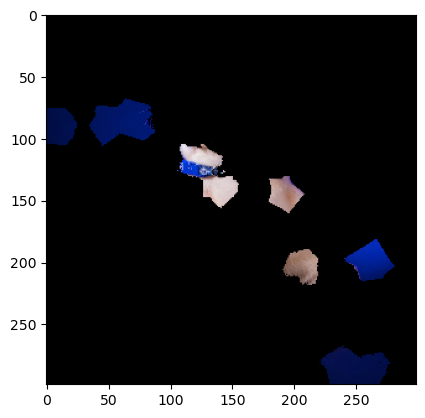

We are now considering class:  beagle
Below we will show the image explaining this prediction (the above class is the prediction)


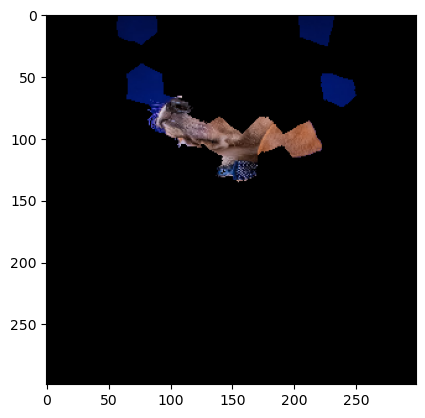

In [10]:
for image in images:
    image_ = image.copy()
    print("The image we are investigating is: ")
    plt.imshow(image_/255.)
    plt.show()
    
    
    classes = []
    top = get_top3(image_)[0]
    for i in range(len(top[0])):
        classes.append(top[0][i][1])
    print(f"The top 3 predicted classes for this image are: ", classes)
    
    interpretable_instances, segments, superpixel_coords = get_interpretable_instances(image_)
    
    # Display the superpixel segments on the original image (for visualization)
    mask = segments.getLabelContourMask()
    image_[mask == 255] = [0, 255, 0]  # Set contour pixels to green
    
    print("The image with the superpixel segments is: ")
    # Display the image with superpixel segments
    plt.imshow(image_/255.)
    plt.show()
    
    binary_vectors = represent_as_binary_vectors(interpretable_instances)
    
    num_superpixels = segments.getNumberOfSuperpixels()
    
    for c in classes:
        print(f"We are now considering class: ", c)
        print("Below we will show the image explaining this prediction (the above class is the prediction)")
        local_dataset = []
        
        pertubations = generate_random_perturbations(binary_vectors)
        
        perturbed_instances = binary_vectors * pertubations
        
        corr_images, corr_labels, corr_label_indexs, label_probs = generate_image_from_interpretable_instance(perturbed_instances, superpixel_coords, image_.shape, (image/255))
        proximity = calculate_similarity_full((image/255),corr_images)

        # Fit linear model with locally weighted loss and L1 regularization
        linear_model = LassoCV(eps=0.001, cv=5, max_iter=10000, tol=0.001)
        linear_model.fit(X=pertubations,y = label_probs, sample_weight = proximity[0])
        coeff = linear_model.coef_
        
        num_top_features = 10
        top_features = np.argsort(np.abs(coeff))[-num_top_features:]
        mask = np.zeros(num_superpixels)
        mask[top_features]= True #Activate top superpixels
        explanation = generate_image_from_interpretable_instance([mask], superpixel_coords, image_.shape, (image/255))[0][0]
        plt.imshow(explanation)
        plt.show()

    
    

# Linear Regression

The image we are investigating is: 


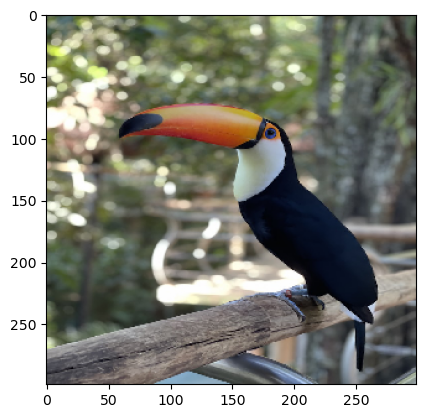

The top 3 predicted classes for this image are:  ['toucan', 'macaw', 'jacamar']
The image with the superpixel segments is: 


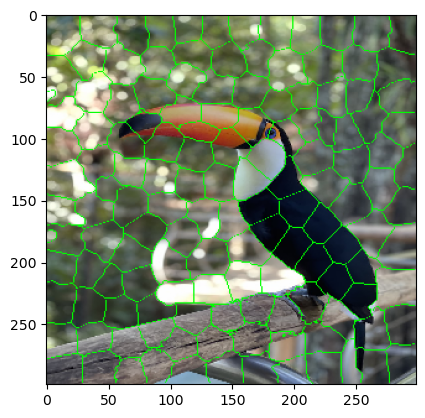

We are now considering class:  toucan
Below we will show the image explaining this prediction (the above class is the prediction)


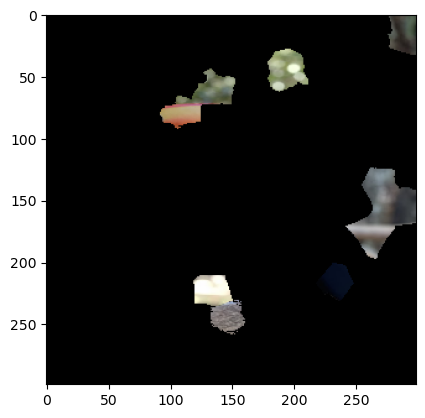

We are now considering class:  macaw
Below we will show the image explaining this prediction (the above class is the prediction)


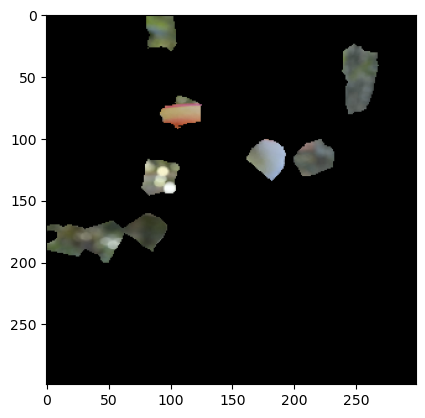

We are now considering class:  jacamar
Below we will show the image explaining this prediction (the above class is the prediction)


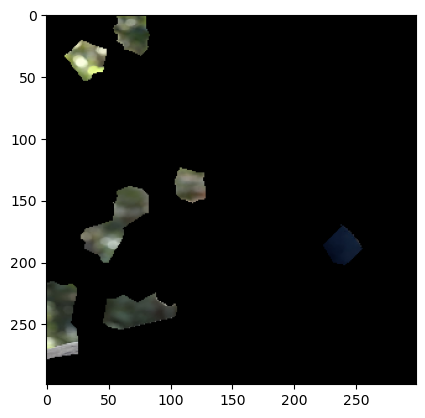

The image we are investigating is: 


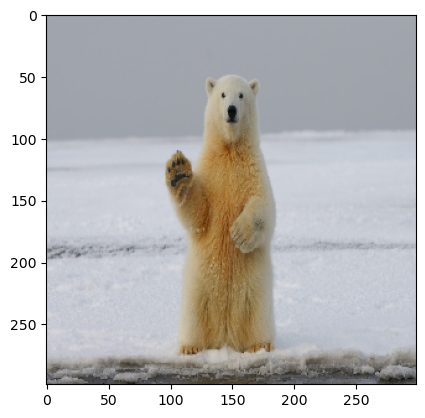

The top 3 predicted classes for this image are:  ['ice_bear', 'Arctic_fox', 'white_wolf']
The image with the superpixel segments is: 


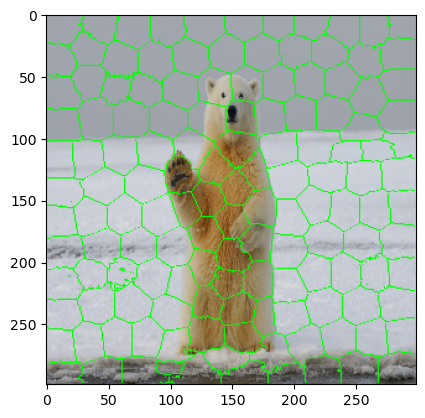

We are now considering class:  ice_bear
Below we will show the image explaining this prediction (the above class is the prediction)


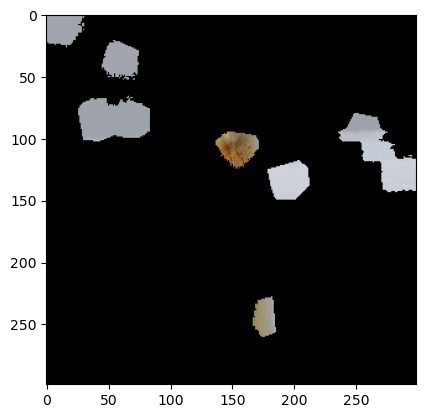

We are now considering class:  Arctic_fox
Below we will show the image explaining this prediction (the above class is the prediction)


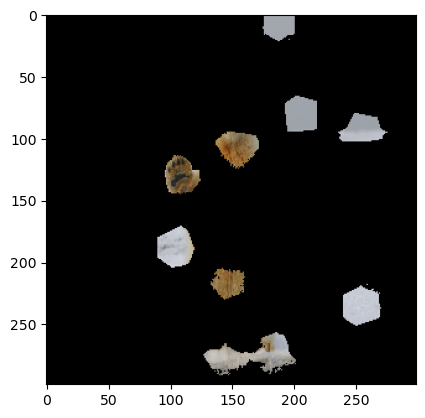

We are now considering class:  white_wolf
Below we will show the image explaining this prediction (the above class is the prediction)


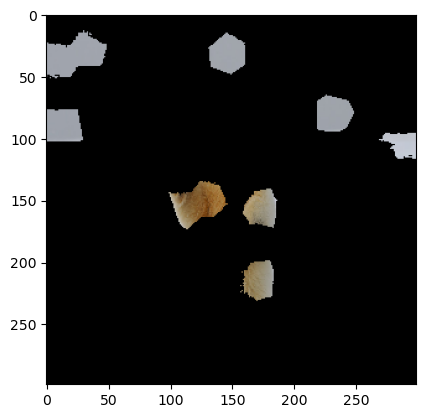

The image we are investigating is: 


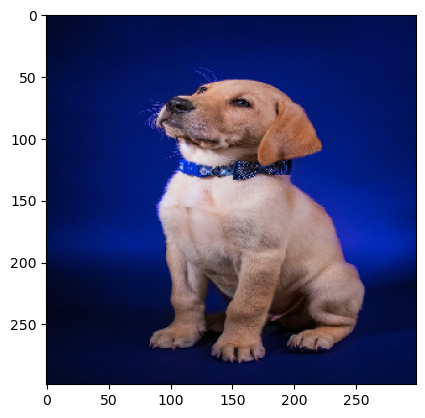

The top 3 predicted classes for this image are:  ['Labrador_retriever', 'golden_retriever', 'beagle']
The image with the superpixel segments is: 


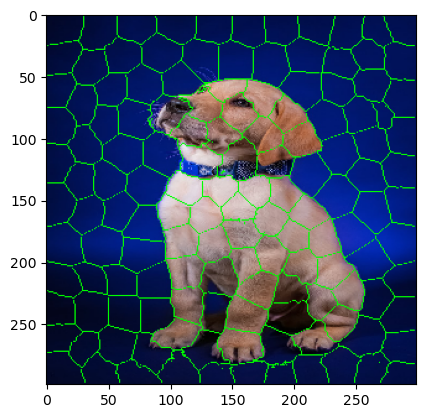

We are now considering class:  Labrador_retriever
Below we will show the image explaining this prediction (the above class is the prediction)


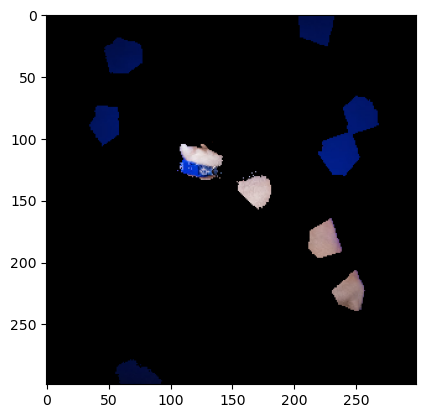

We are now considering class:  golden_retriever
Below we will show the image explaining this prediction (the above class is the prediction)


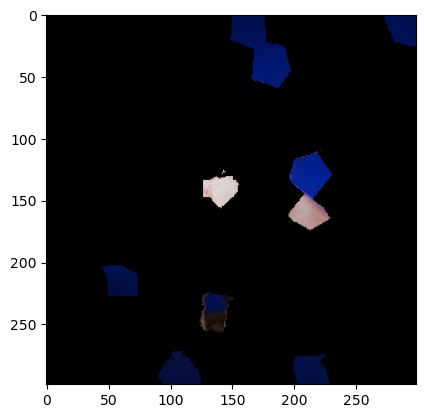

We are now considering class:  beagle
Below we will show the image explaining this prediction (the above class is the prediction)


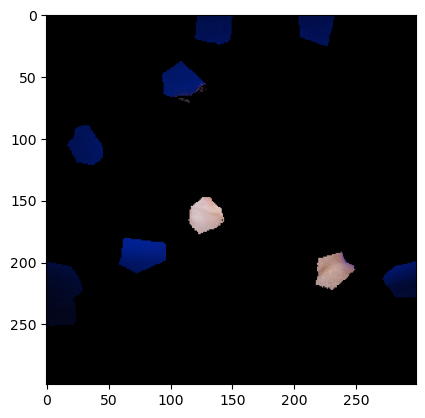

In [11]:
for image in images:
    image_ = image.copy()
    print("The image we are investigating is: ")
    plt.imshow(image_/255.)
    plt.show()
    
    
    classes = []
    top = get_top3(image_)[0]
    for i in range(len(top[0])):
        classes.append(top[0][i][1])
    print(f"The top 3 predicted classes for this image are: ", classes)
    
    interpretable_instances, segments, superpixel_coords = get_interpretable_instances(image_)
    
    # Display the superpixel segments on the original image (for visualization)
    mask = segments.getLabelContourMask()
    image_[mask == 255] = [0, 255, 0]  # Set contour pixels to green
    
    print("The image with the superpixel segments is: ")
    # Display the image with superpixel segments
    plt.imshow(image_/255.)
    plt.show()
    
    binary_vectors = represent_as_binary_vectors(interpretable_instances)
    
    num_superpixels = segments.getNumberOfSuperpixels()
    
    for c in classes:
        print(f"We are now considering class: ", c)
        print("Below we will show the image explaining this prediction (the above class is the prediction)")
        local_dataset = []
        
        pertubations = generate_random_perturbations(binary_vectors)
        
        perturbed_instances = binary_vectors * pertubations
        
        corr_images, corr_labels, corr_label_indexs, label_probs = generate_image_from_interpretable_instance(perturbed_instances, superpixel_coords, image_.shape, (image/255))
        proximity = calculate_similarity_full((image/255),corr_images)

        linear_model = LinearRegression()
        linear_model.fit(X=pertubations,y = label_probs, sample_weight = proximity[0])
        coeff = linear_model.coef_
        num_top_features = 10
        top_features = np.argsort(np.abs(coeff))[-num_top_features:]
        mask = np.zeros(num_superpixels)
        mask[top_features]= True #Activate top superpixels
        explanation = generate_image_from_interpretable_instance([mask], superpixel_coords, image_.shape, (image/255))[0][0]
        plt.imshow(explanation)
        plt.show()

    
    